# Written by Tiffany Patafio for HW 4 Assignment 2

Using CitiBike Data, come up with an analysis that can be performed as well as a hypothesis and NULL hypothesis.


In [33]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
from scipy import stats

%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

import os
import json

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Idea: 
Non-membership usage (likely driven by leasure bikers, tourists & visitors) is highest on weekends.

# Null Hypothesis: 
The average number of daily trips using 24 hour passes or 3 day passes on weekends (E) in NYC during August 2018 is the same or lower than the average amount on weekdays (D) during the same time period with a significance level of .10. (Weekends=Saturday and Sunday)

H0: E-D<=0

# Alternative Hypothesis: 
The average number of daily trips using 24 hour passes or 3 day passes on weekends (E) during August 2018 is significantly higher than the average amount on weekdays (D) during this same period.

H1: E-D>0

In [3]:
#Download NY Citywide Payroll data from URL and add to PUIDATA
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

### ***!!Uncomment below to download data!!!***

In [4]:
#Download data for August 2018
datestring = '201808'
#getCitiBikeCSV(datestring)

In [5]:
#read data from trip data csv file into dataframe
df=pd.read_csv(os.getenv("PUIDATA")+"/201808-citibike-tripdata.csv")

In [6]:
#review the data in the csv file
df.head()

tripduration                 starttime                  stoptime  \
0           681  2018-08-01 00:00:07.3210  2018-08-01 00:11:28.9920   
1           625  2018-08-01 00:00:19.7480  2018-08-01 00:10:45.0290   
2          1319  2018-08-01 00:00:21.1750  2018-08-01 00:22:20.6370   
3           220  2018-08-01 00:00:26.4700  2018-08-01 00:04:06.8190   
4           398  2018-08-01 00:00:30.2910  2018-08-01 00:07:09.2810   

   start station id       start station name  start station latitude  \
0            3162.0       W 78 St & Broadway               40.783400   
1            3260.0  Mercer St & Bleecker St               40.727064   
2             403.0           E 2 St & 2 Ave               40.725029   
3            3637.0  Fulton St & Waverly Ave               40.683239   
4            3662.0     31 Ave & Steinway St               40.761294   

   start station longitude  end station id             end station name  \
0               -73.980931          3383.0    Cathedral Pkwy & Broadway   
1               -73.996621          2012.0              E 27 St & 1 Ave   
2               -73.990697           285.0           Broadway & E 14 St   
3               -73.965996           399.0  Lafayette Ave & St James Pl   
4               -73.916917          3517.0           31 St & Hoyt Ave N   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.804213             -73.966991   27770  Subscriber   
1             40.739445             -73.976806   25938  Subscriber   
2             40.734546             -73.990741   28679  Subscriber   
3             40.688515             -73.964763   28075  Subscriber   
4             40.771153             -73.917007   25002  Subscriber   

   birth year  gender  
0        1986       1  
1        1969       1  
2        1970       1  
3        1982       1  
4        1987       1

In [7]:
#add a date time attribute
df['date']=pd.to_datetime(df['starttime'])
df['day_of_week'] = df['date'].dt.weekday_name
df['shortdate']=df['date'].dt.strftime('%m/%d/%Y')
df.head()

tripduration                 starttime                  stoptime  \
0           681  2018-08-01 00:00:07.3210  2018-08-01 00:11:28.9920   
1           625  2018-08-01 00:00:19.7480  2018-08-01 00:10:45.0290   
2          1319  2018-08-01 00:00:21.1750  2018-08-01 00:22:20.6370   
3           220  2018-08-01 00:00:26.4700  2018-08-01 00:04:06.8190   
4           398  2018-08-01 00:00:30.2910  2018-08-01 00:07:09.2810   

   start station id       start station name  start station latitude  \
0            3162.0       W 78 St & Broadway               40.783400   
1            3260.0  Mercer St & Bleecker St               40.727064   
2             403.0           E 2 St & 2 Ave               40.725029   
3            3637.0  Fulton St & Waverly Ave               40.683239   
4            3662.0     31 Ave & Steinway St               40.761294   

   start station longitude  end station id             end station name  \
0               -73.980931          3383.0    Cathedral Pkwy & Broadway   
1               -73.996621          2012.0              E 27 St & 1 Ave   
2               -73.990697           285.0           Broadway & E 14 St   
3               -73.965996           399.0  Lafayette Ave & St James Pl   
4               -73.916917          3517.0           31 St & Hoyt Ave N   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.804213             -73.966991   27770  Subscriber   
1             40.739445             -73.976806   25938  Subscriber   
2             40.734546             -73.990741   28679  Subscriber   
3             40.688515             -73.964763   28075  Subscriber   
4             40.771153             -73.917007   25002  Subscriber   

   birth year  gender                    date day_of_week   shortdate  
0        1986       1 2018-08-01 00:00:07.321   Wednesday  08/01/2018  
1        1969       1 2018-08-01 00:00:19.748   Wednesday  08/01/2018  
2        1970       1 2018-08-01 00:00:21.175   Wednesday  08/01/2018  
3        1982       1 2018-08-01 00:00:26.470   Wednesday  08/01/2018  
4        1987       1 2018-08-01 00:00:30.291   Wednesday  08/01/2018

In [8]:
#create an additional column that indicates 'weekday' or 'weekend' called Weekend
conditions = [
    (df['day_of_week'] == 'Saturday'),
    (df['day_of_week'] == 'Sunday'),]
choices=['weekend', 'weekend']

In [9]:
df['weekend']=np.select(conditions, choices, default='weekday')

In [10]:
# review & remove unnecessary columns
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'date', 'day_of_week', 'shortdate', 'weekend'],
      dtype='object')

In [11]:
df.head()

tripduration                 starttime                  stoptime  \
0           681  2018-08-01 00:00:07.3210  2018-08-01 00:11:28.9920   
1           625  2018-08-01 00:00:19.7480  2018-08-01 00:10:45.0290   
2          1319  2018-08-01 00:00:21.1750  2018-08-01 00:22:20.6370   
3           220  2018-08-01 00:00:26.4700  2018-08-01 00:04:06.8190   
4           398  2018-08-01 00:00:30.2910  2018-08-01 00:07:09.2810   

   start station id       start station name  start station latitude  \
0            3162.0       W 78 St & Broadway               40.783400   
1            3260.0  Mercer St & Bleecker St               40.727064   
2             403.0           E 2 St & 2 Ave               40.725029   
3            3637.0  Fulton St & Waverly Ave               40.683239   
4            3662.0     31 Ave & Steinway St               40.761294   

   start station longitude  end station id             end station name  \
0               -73.980931          3383.0    Cathedral Pkwy & Broadway   
1               -73.996621          2012.0              E 27 St & 1 Ave   
2               -73.990697           285.0           Broadway & E 14 St   
3               -73.965996           399.0  Lafayette Ave & St James Pl   
4               -73.916917          3517.0           31 St & Hoyt Ave N   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.804213             -73.966991   27770  Subscriber   
1             40.739445             -73.976806   25938  Subscriber   
2             40.734546             -73.990741   28679  Subscriber   
3             40.688515             -73.964763   28075  Subscriber   
4             40.771153             -73.917007   25002  Subscriber   

   birth year  gender                    date day_of_week   shortdate  weekend  
0        1986       1 2018-08-01 00:00:07.321   Wednesday  08/01/2018  weekday  
1        1969       1 2018-08-01 00:00:19.748   Wednesday  08/01/2018  weekday  
2        1970       1 2018-08-01 00:00:21.175   Wednesday  08/01/2018  weekday  
3        1982       1 2018-08-01 00:00:26.470   Wednesday  08/01/2018  weekday  
4        1987       1 2018-08-01 00:00:30.291   Wednesday  08/01/2018  weekday

In [12]:
#remove columns
Limit=df.drop(['start station id', 'start station name', 'start station latitude',
        'start station longitude', 'end station id', 'end station name', 'birth year', 'gender',
        'end station latitude', 'end station longitude'], axis=1 )

In [13]:
#limit data to subscribers
subscribers=Limit[Limit['usertype']=='Customer']

In [14]:
#confirm dataset looks accurate
subscribers[subscribers['day_of_week']=='Sunday']

tripduration                 starttime                  stoptime  \
247326           1550  2018-08-05 00:00:13.7930  2018-08-05 00:26:04.4530   
247328           2578  2018-08-05 00:00:19.8040  2018-08-05 00:43:18.5450   
247337           1561  2018-08-05 00:00:45.8380  2018-08-05 00:26:47.5780   
247342           1149  2018-08-05 00:01:15.1650  2018-08-05 00:20:25.0770   
247346            157  2018-08-05 00:01:18.5670  2018-08-05 00:03:55.6620   
247347           2617  2018-08-05 00:01:18.6490  2018-08-05 00:44:55.8190   
247351           1749  2018-08-05 00:01:33.9130  2018-08-05 00:30:43.6260   
247355           1100  2018-08-05 00:01:50.3910  2018-08-05 00:20:11.0830   
247356           1086  2018-08-05 00:01:51.4870  2018-08-05 00:19:58.0630   
247359           1642  2018-08-05 00:01:57.8360  2018-08-05 00:29:20.2600   
247378            407  2018-08-05 00:03:28.4030  2018-08-05 00:10:15.9910   
247381           1553  2018-08-05 00:03:38.6400  2018-08-05 00:29:32.5120   
247382            390  2018-08-05 00:03:38.8960  2018-08-05 00:10:09.0850   
247390           1789  2018-08-05 00:03:58.5610  2018-08-05 00:33:48.4810   
247399            692  2018-08-05 00:04:24.7570  2018-08-05 00:15:57.4110   
247422            945  2018-08-05 00:06:10.0370  2018-08-05 00:21:55.8330   
247456            569  2018-08-05 00:08:24.8820  2018-08-05 00:17:54.5550   
247463           1334  2018-08-05 00:08:59.6450  2018-08-05 00:31:14.3040   
247464           1017  2018-08-05 00:09:02.7300  2018-08-05 00:26:00.1180   
247471            925  2018-08-05 00:09:41.4350  2018-08-05 00:25:06.5410   
247474           1116  2018-08-05 00:09:46.8430  2018-08-05 00:28:23.8380   
247479            900  2018-08-05 00:10:01.6600  2018-08-05 00:25:01.6640   
247483           1413  2018-08-05 00:10:21.9840  2018-08-05 00:33:55.7060   
247486           1870  2018-08-05 00:10:45.0290  2018-08-05 00:41:55.6980   
247487           1366  2018-08-05 00:10:44.8420  2018-08-05 00:33:31.3150   
247497           1288  2018-08-05 00:11:38.5460  2018-08-05 00:33:07.1980   
247503           1253  2018-08-05 00:11:55.0310  2018-08-05 00:32:48.5900   
247506            979  2018-08-05 00:11:58.1460  2018-08-05 00:28:17.9600   
247507           1014  2018-08-05 00:11:58.4740  2018-08-05 00:28:53.3180   
247511            965  2018-08-05 00:12:11.4990  2018-08-05 00:28:16.8190   
...               ...                       ...                       ...   
1650107          1261  2018-08-26 23:42:20.6280  2018-08-27 00:03:22.2850   
1650113           793  2018-08-26 23:43:01.5210  2018-08-26 23:56:15.3590   
1650120           743  2018-08-26 23:43:51.5590  2018-08-26 23:56:14.6990   
1650134          1134  2018-08-26 23:45:30.1120  2018-08-27 00:04:24.3270   
1650142          1158  2018-08-26 23:45:58.1980  2018-08-27 00:05:17.0890   
1650144           830  2018-08-26 23:46:07.1690  2018-08-26 23:59:58.0430   
1650145          2315  2018-08-26 23:46:09.4250  2018-08-27 00:24:45.2090   
1650151          5632  2018-08-26 23:46:27.8940  2018-08-27 01:20:20.7310   
1650162          1126  2018-08-26 23:48:18.9780  2018-08-27 00:07:05.7940   
1650166          1110  2018-08-26 23:48:29.1480  2018-08-27 00:07:00.0960   
1650169           440  2018-08-26 23:48:39.9810  2018-08-26 23:56:00.6810   
1650172           447  2018-08-26 23:48:49.3480  2018-08-26 23:56:17.2740   
1650173           449  2018-08-26 23:48:51.0220  2018-08-26 23:56:20.6640   
1650178          2466  2018-08-26 23:49:27.2820  2018-08-27 00:30:33.6480   
1650189           648  2018-08-26 23:50:26.1360  2018-08-27 00:01:14.4400   
1650190           623  2018-08-26 23:50:45.0120  2018-08-27 00:01:08.8280   
1650195          2761  2018-08-26 23:51:14.8590  2018-08-27 00:37:16.4870   
1650199          2748  2018-08-26 23:51:33.8720  2018-08-27 00:37:22.1450   
1650227          1530  2018-08-26 23:54:19.8770  2018-08-27 00:19:50.8120   
1650230          1585  2018-08-26 23:54:30.7300  2018-08-27 00:20:56.5940   
16502

In [15]:
#counting number of days in the month for weekends and weekdays
num_e=subscribers[subscribers['weekend']=="weekend"].shortdate.nunique()
num_d=subscribers[subscribers['weekend']=="weekday"].shortdate.nunique()

In [16]:
#creating new metrics to calculate the average daily trips
subscribers_e=subscribers[subscribers.weekend=='weekend'].groupby([subscribers.weekend]).count()
subscribers_d=subscribers[subscribers.weekend=='weekday'].groupby([subscribers.weekend]).count()
subscribers_enorm=subscribers_e/num_e
subscribers_dnorm=subscribers_d/num_d

Text(0.5,1,'Average Daily number of rides on Weekends vs Weekdays')

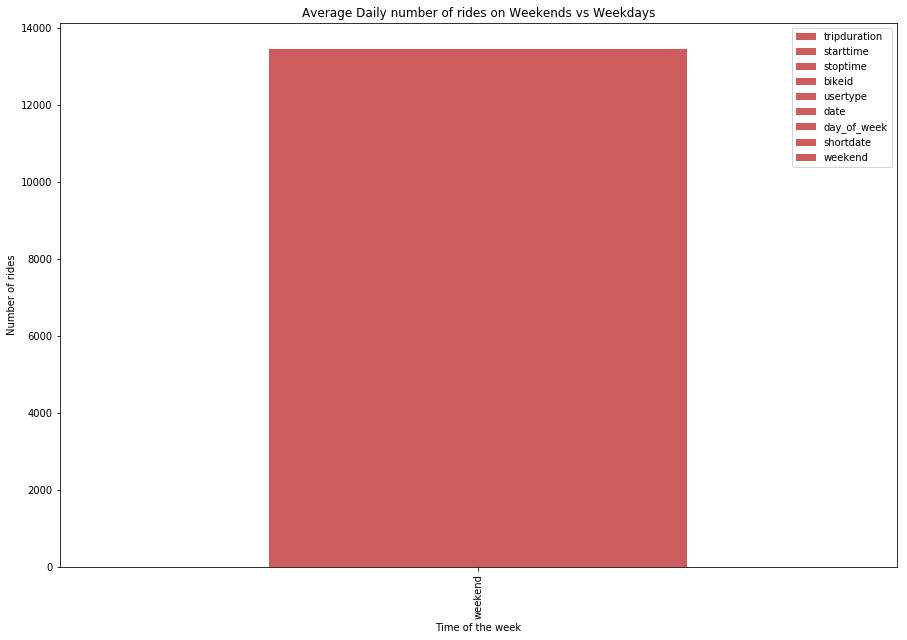

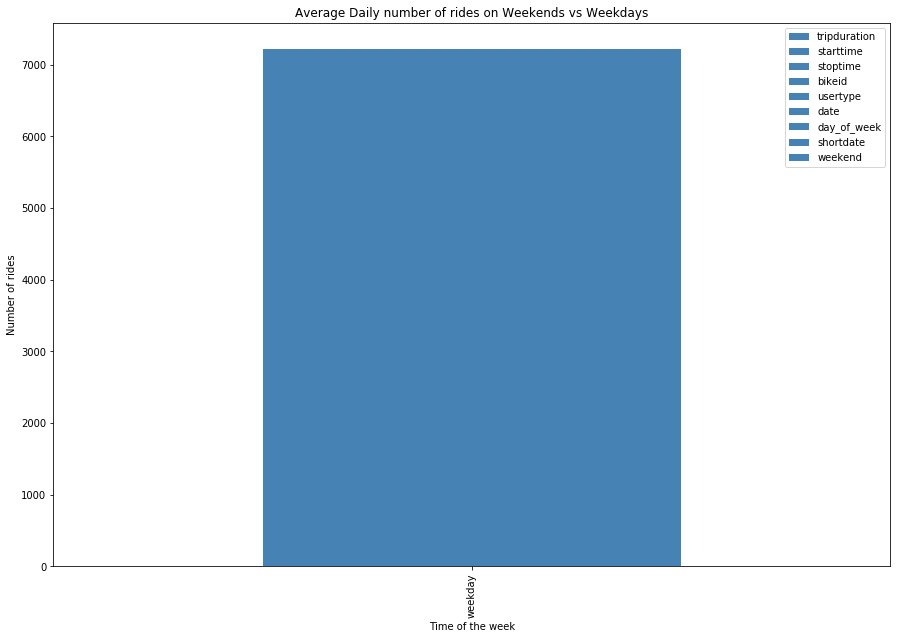

In [17]:
fig=pl.figure(figsize(15,10))
ax=subscribers_enorm.plot(kind="bar", color="IndianRed", label="Weekend")
ax1=subscribers_dnorm.plot(kind="bar", color="SteelBlue", label="Weekday")
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Time of the week")
ax.set_title ("Average Daily number of rides on Weekends vs Weekdays")
ax1.set_ylabel ("Number of rides")
ax1.set_xlabel ("Time of the week")
ax1.set_title ("Average Daily number of rides on Weekends vs Weekdays")

Text(0.5,1,'Average Daily number of rides on Weekends vs Weekdays')

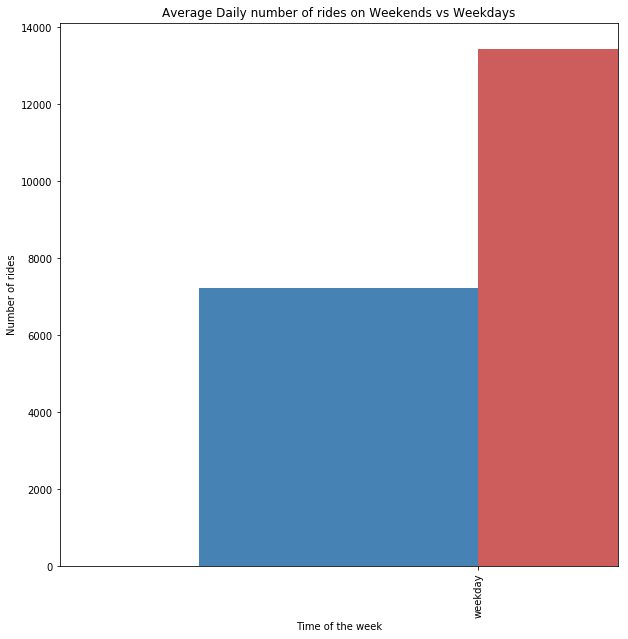

In [64]:
f, ax = plt.subplots(figsize=(10,10))
subscribers_enorm.bikeid.plot(kind="bar", color="IndianRed", label="Weekend", ax=ax, stacked=False, position=0)
subscribers_dnorm.bikeid.plot(kind="bar", color="SteelBlue", label="Weekday", ax=ax, stacked=False, position=1)
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Time of the week")
ax.set_title ("Average Daily number of rides on Weekends vs Weekdays")

Figure 1: The figures above show the average number of daily trips for August 2018 for weekend days (red) and weekdays (blue). There is a consdirably higher number of daily trips (almost 14K) on weekends than weekdays (~7k).

Text(0.5,1,'Total Number of rides on Weekends vs Weekdays')

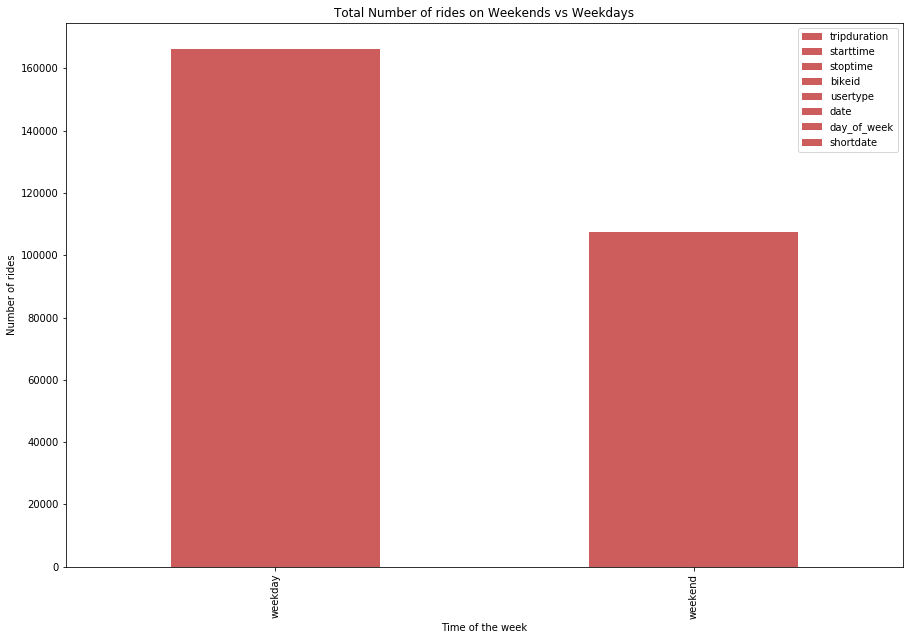

In [18]:
fig=pl.figure(figsize(15,10))
plot=subscribers.groupby([subscribers.weekend]).count().plot(kind="bar", color="IndianRed")
plot.set_ylabel ("Number of rides")
plot.set_xlabel ("Time of the week")
plot.set_title ("Total Number of rides on Weekends vs Weekdays")

Figure 2: The figure above shows the total number of subscriber rides in August 2018 separated by weekday and weekend. Note that there are 23 weekdays in August and only 8 weekends but number of trips on weekends is greater than half weekdays.

In [24]:
weekendtrips=subscribers[subscribers.weekend=='weekend'].groupby([subscribers.shortdate]).count()
weekdaytrips=subscribers[subscribers.weekend=='weekday'].groupby([subscribers.shortdate]).count()

In [32]:
wknd_av=weekendtrips.weekend.mean()
wkdy_av=weekdaytrips.weekend.mean()
wknd_sd=weekendtrips.weekend.std()
wkdy_sd=weekdaytrips.weekend.std()
print('weekend: %f,%f'%(wknd_av,wknd_sd))
print('weekday: %f,%f'%(wkdy_av, wkdy_sd))

weekend: 13445.875000,3724.048965
weekday: 7224.086957,1453.673651


In [36]:
from scipy import stats

In [40]:
stats.mannwhitneyu(weekendtrips,weekdaytrips)

MannwhitneyuResult(statistic=-1620.0, pvalue=0.0)

With a p value of 0.0, we can reject the NULL hypothesis that the avergae number of trips per day using 24 hour or 3 day passes on weekends in NYC during August 2018 is the same or lower than the average on weekdays during the same period. Therefore, we can conclude that there is a higher number of trips using 24 hour or 3 day passes, potentially purchased for leisure or by visitors, on weekends than during the week.